In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import basic libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**Load the regression dataset**

In [3]:
df_reg_raw = pd.read_csv("AB_NYC_2019.csv")
print("Dataset shape:", df_reg_raw.shape)
df_reg_raw.head()


Dataset shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


**Dataset info**

In [4]:
df_reg_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

**Check missing values**

In [5]:
df_reg_raw.isna().sum().sort_values(ascending=False).head(15)


,0
last_review,10052
reviews_per_month,10052
host_name,21
name,16
neighbourhood_group,0
neighbourhood,0
id,0
host_id,0
longitude,0
latitude,0


**Select target column**

In [6]:
df_reg_raw["price"].describe()


,price
count,48895.000000
mean,152.720687
std,240.154170
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


**Drop unnecessary columns + handle missing values**

In [7]:
df_reg = df_reg_raw.copy()

# drop unnecessary columns
df_reg = df_reg.drop(["id", "name", "host_name", "last_review"], axis=1)

# fill missing values
df_reg["reviews_per_month"] = df_reg["reviews_per_month"].fillna(df_reg["reviews_per_month"].median())

print("Missing values after cleaning:")
df_reg.isna().sum().sort_values(ascending=False).head(10)


Missing values after cleaning:


,0
host_id,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,0


**Sampling for faster execution**

In [8]:
df_reg = df_reg.sample(40000, random_state=42)
print("Sampled shape:", df_reg.shape)


Sampled shape: (40000, 12)


**EDA - Price distribution**

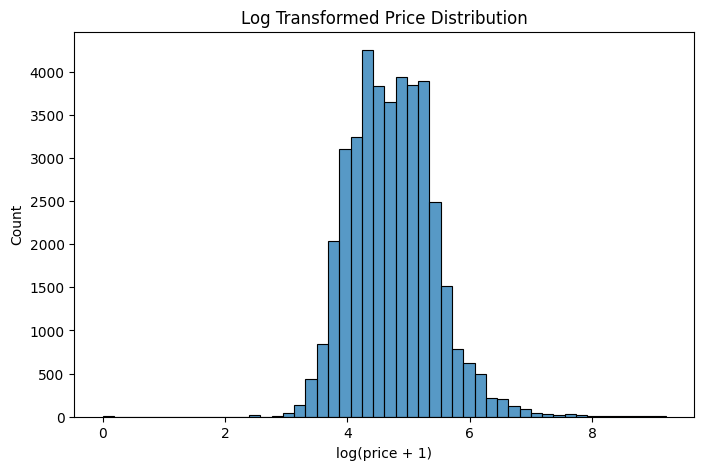

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df_reg["price"]), bins=50)
plt.title("Log Transformed Price Distribution")
plt.xlabel("log(price + 1)")
plt.show()


The price distribution is highly skewed due to extreme outliers. Therefore, the plots were limited to reasonable ranges and log transformation was applied for better visualization.

**EDA - Price by Room Type**

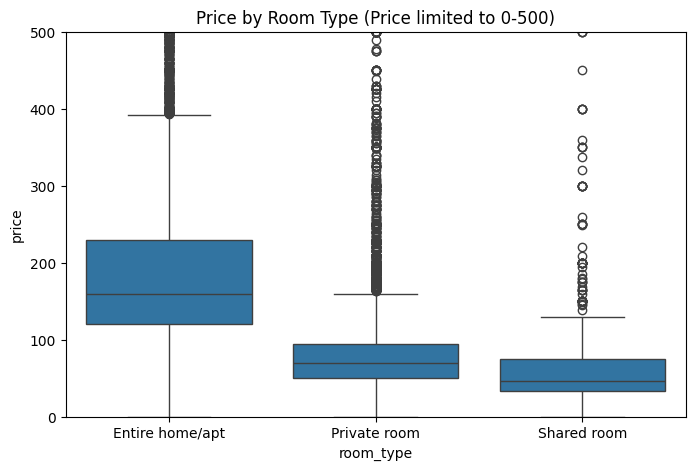

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x="room_type", y="price", data=df_reg)
plt.ylim(0, 500)   # limits view
plt.title("Price by Room Type (Price limited to 0-500)")
plt.show()


**Correlation heatmap**

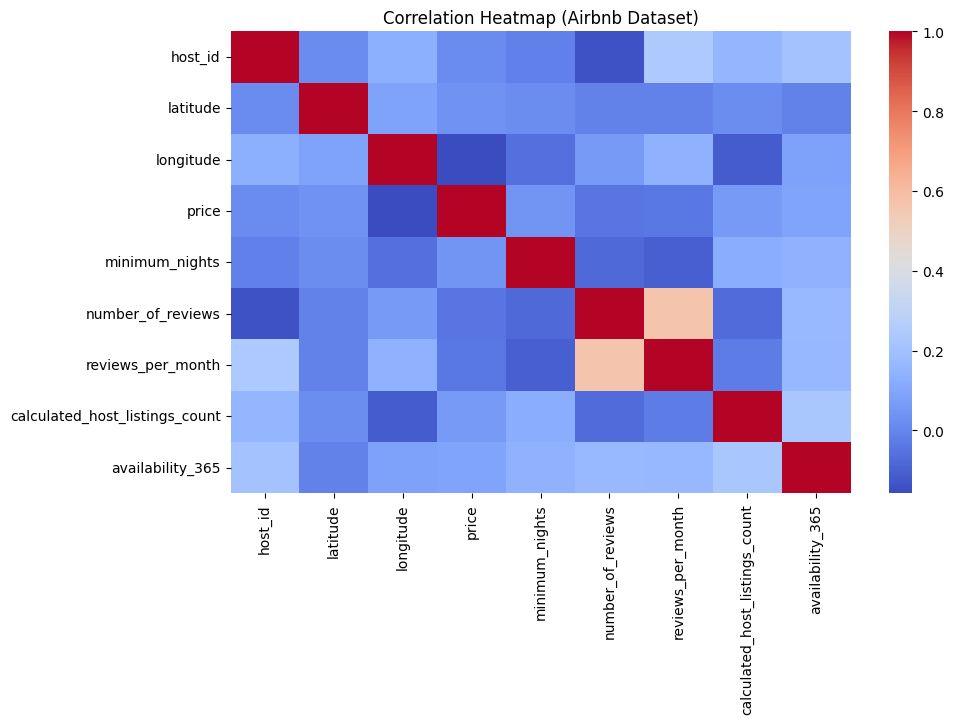

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(df_reg.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Heatmap (Airbnb Dataset)")
plt.show()


**Create X and y**

In [12]:
X = df_reg.drop("price", axis=1)
y = df_reg["price"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (40000, 11)
y shape: (40000,)


**Train-test split**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (32000, 11) Test: (8000, 11)


**Preprocessing (Encoding + Scaling)**

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


**Train classical model 1 - Linear Regression**

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))
print("Linear Regression R2:", r2_score(y_test, pred_lr))


Linear Regression MAE: 69.21296896602007
Linear Regression RMSE: 198.09902139975088
Linear Regression R2: 0.1157704918092245


**Train classical model 2 - Decision Tree Regressor**

In [17]:
from sklearn.tree import DecisionTreeRegressor

dt_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=10))
])

dt_reg_model.fit(X_train, y_train)
pred_dt = dt_reg_model.predict(X_test)

print("Decision Tree MAE:", mean_absolute_error(y_test, pred_dt))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, pred_dt)))
print("Decision Tree R2:", r2_score(y_test, pred_dt))


Decision Tree MAE: 66.06293873390443
Decision Tree RMSE: 238.34315786775537
Decision Tree R2: -0.2799874805760416


**Neural Network model - MLPRegressor**

In [25]:
from sklearn.neural_network import MLPRegressor

mlp_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", MLPRegressor(hidden_layer_sizes=(64,32), max_iter=50, random_state=42))
])

mlp_reg_model.fit(X_train, y_train)
pred_mlp = mlp_reg_model.predict(X_test)

print("MLPRegressor MAE:", mean_absolute_error(y_test, pred_mlp))
print("MLPRegressor RMSE:", np.sqrt(mean_squared_error(y_test, pred_mlp)))
print("MLPRegressor R2:", r2_score(y_test, pred_mlp))


MLPRegressor MAE: 66.1980627755971
MLPRegressor RMSE: 194.73906246010978
MLPRegressor R2: 0.1455109666183153


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


**Hyperparameter tuning - Decision Tree Regressor**

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    "model__max_depth": [5, 10, 15],
    "model__min_samples_split": [2, 10, 50],
    "model__min_samples_leaf": [1, 5, 10]
}

grid_dt_reg = GridSearchCV(dt_reg_model, param_grid_dt, cv=3, scoring="r2", n_jobs=-1)
grid_dt_reg.fit(X_train, y_train)

best_dt_reg = grid_dt_reg.best_estimator_
pred_dt_tuned = best_dt_reg.predict(X_test)

print("Best Decision Tree Params:", grid_dt_reg.best_params_)
print("Tuned DT MAE:", mean_absolute_error(y_test, pred_dt_tuned))
print("Tuned DT RMSE:", np.sqrt(mean_squared_error(y_test, pred_dt_tuned)))
print("Tuned DT R2:", r2_score(y_test, pred_dt_tuned))


Best Decision Tree Params: {'model__max_depth': 10, 'model__min_samples_leaf': 10, 'model__min_samples_split': 50}
Tuned DT MAE: 66.1436166132298
Tuned DT RMSE: 204.16395948190439
Tuned DT R2: 0.06079909371033765


**Feature selection using SelectKBest (f_regression)**

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression

fs_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("select", SelectKBest(score_func=f_regression, k=20)),
    ("model", LinearRegression())
])

fs_reg_model.fit(X_train, y_train)
pred_fs = fs_reg_model.predict(X_test)

print("Feature Selected Linear Regression MAE:", mean_absolute_error(y_test, pred_fs))
print("Feature Selected Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, pred_fs)))
print("Feature Selected Linear Regression R2:", r2_score(y_test, pred_fs))


Feature Selected Linear Regression MAE: 69.76937861553321
Feature Selected Linear Regression RMSE: 198.15891269978573
Feature Selected Linear Regression R2: 0.11523575256874352


**Final comparison table**

In [21]:
def reg_row(name, y_true, y_pred):
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

results_reg = pd.DataFrame([
    reg_row("Linear Regression", y_test, pred_lr),
    reg_row("Decision Tree", y_test, pred_dt),
    reg_row("MLPRegressor (Neural Net)", y_test, pred_mlp),
    reg_row("Decision Tree (Tuned)", y_test, pred_dt_tuned),
    reg_row("Linear Regression (Feature Selected)", y_test, pred_fs)
])

results_reg


,Model,MAE,RMSE,R2
0,Linear Regression,69.212969,198.099021,0.115770
1,Decision Tree,66.062939,238.343158,-0.279987
2,MLPRegressor (Neural Net),66.198063,194.739062,0.145511
3,Decision Tree (Tuned),66.143617,204.163959,0.060799
4,Linear Regression (Feature Selected),69.769379,198.158913,0.115236
